In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
b = BLEPipeline()

In [4]:
# b.extract_packet_features(create_master=True)

In [5]:
df = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


In [6]:
features_list = [
    # Packet info
    "PacketLength", "BLE_LL_Length", "Time", 
    
    # Associate Packets
    "Assoc_Packets",
    
    # Channel number
    "Channel_0", "Channel_12", "Channel_39",
    
    # PDU Type
    "SCAN_RSP", "ADV_IND", "SCAN_REQ", 
    "CONNECT_REQ", "ADV_NONCONN_IND", "ADV_DIRECT_IND"]

y_list = ["door", "lock", "temp"]

## Resample

### Downsampling

In [7]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'DeviceName', 'Set', 
                  'AccessAddr', 'AdvertAddr','PDUTypeNum'}
onehotEncoded_vars = {'ADV_DIRECT_IND', 'ADV_IND', 
                      'ADV_NONCONN_IND', 'ADV_SCAN_IND', 
                      'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP'}
response_vars = {"DeviceType","door","lock","temp"}
ble_devicetypes = ["door","lock","temp"]

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | onehotEncoded_vars
X = df_train.drop(col_drop, axis=1)

### Create trial dataframes

In [8]:
df_trials = []
num_trials = 10
while len(df_trials) != num_trials:
    df_downsampled = b.downsample(X, y, df[df["Set"]=="test"])

    # Ensure that the trial sample contains all features in feature list
    if set(features_list).issubset(set(df_downsampled.columns)):
        df_trials.append(df_downsampled)

## Run trials

In [9]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = b.one_vs_all_classify(trial, [x for x in features_list if x in trial.columns], y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports

### Plot ROC plots, report AUC

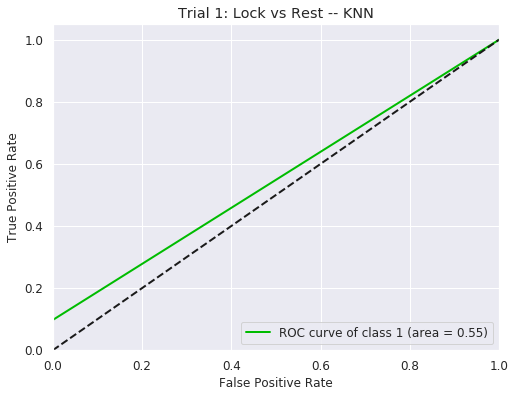

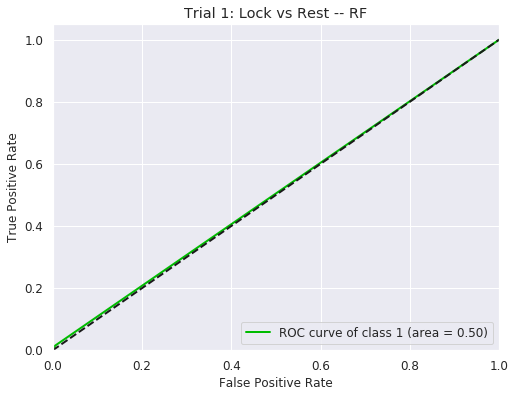

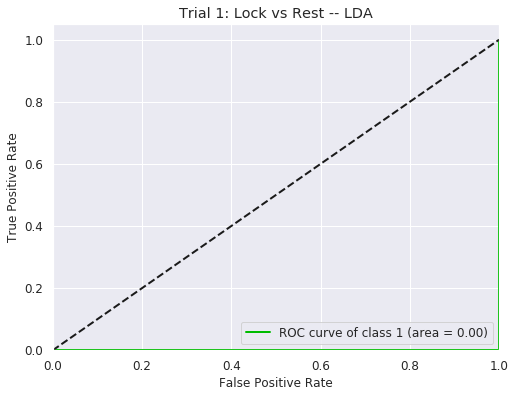

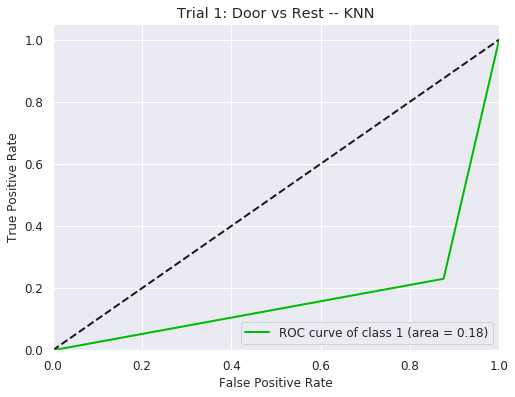

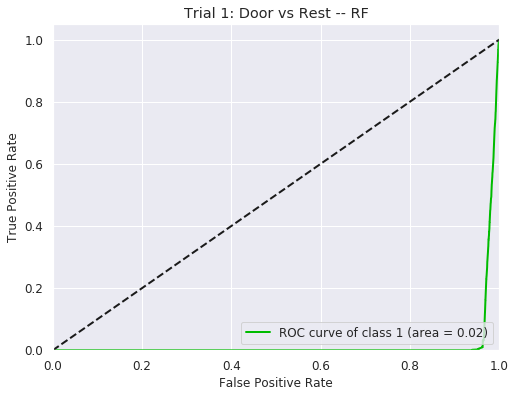

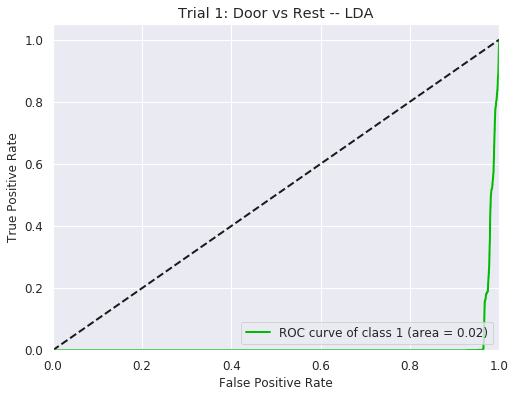

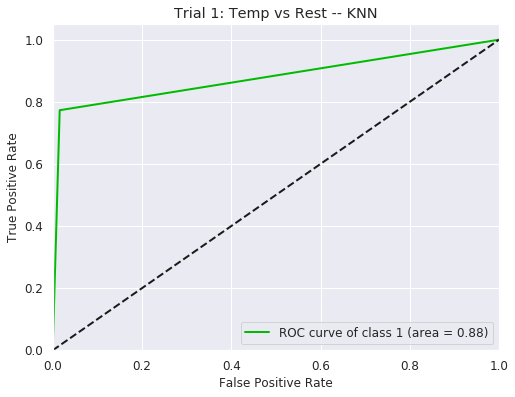

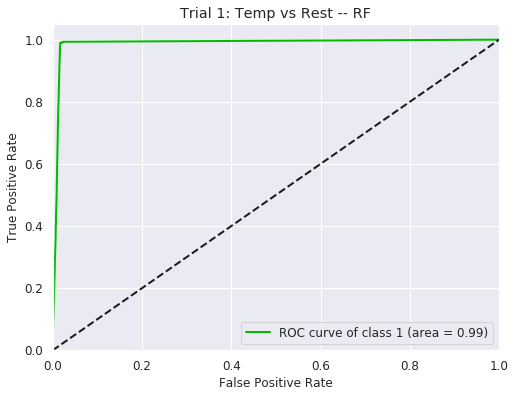

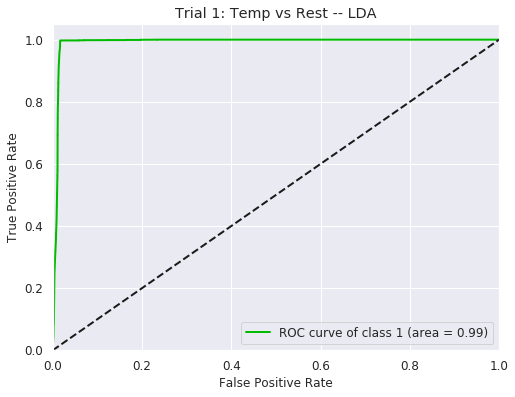

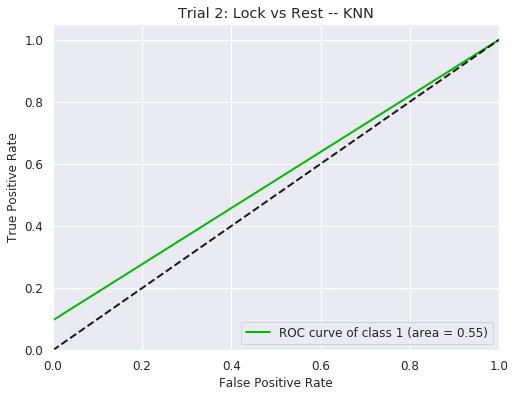

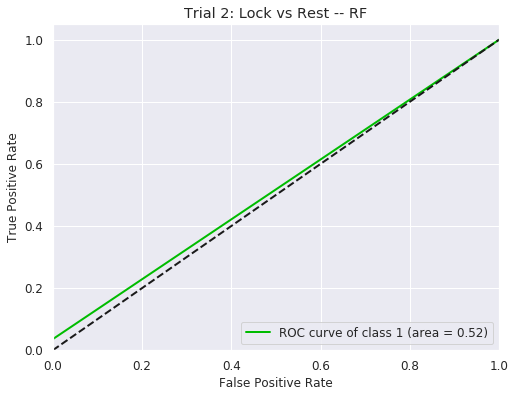

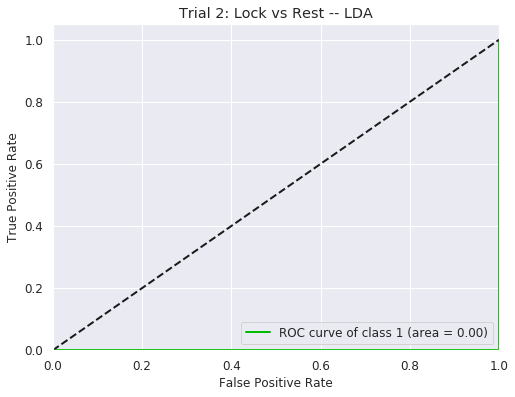

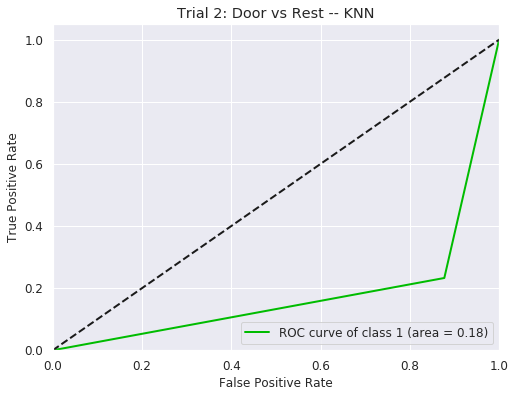

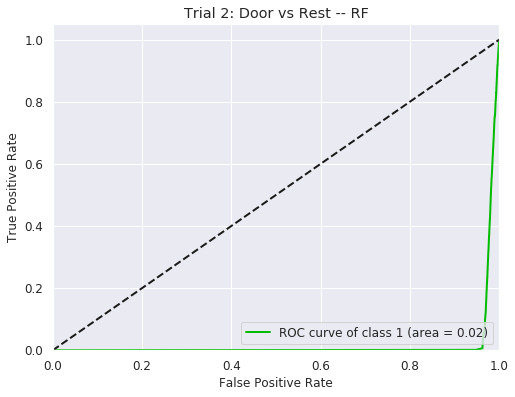

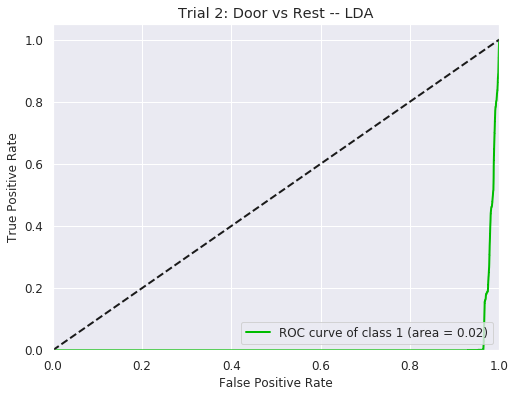

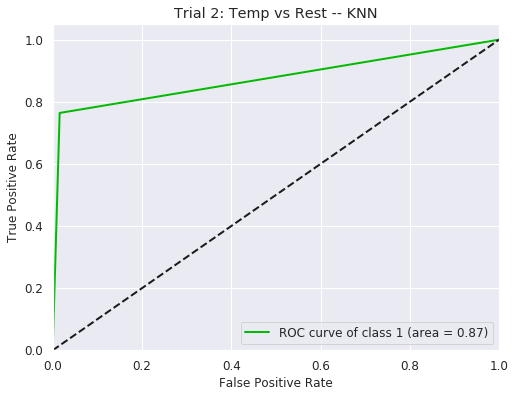

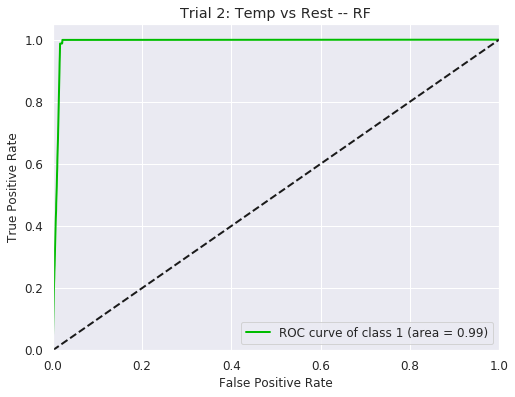

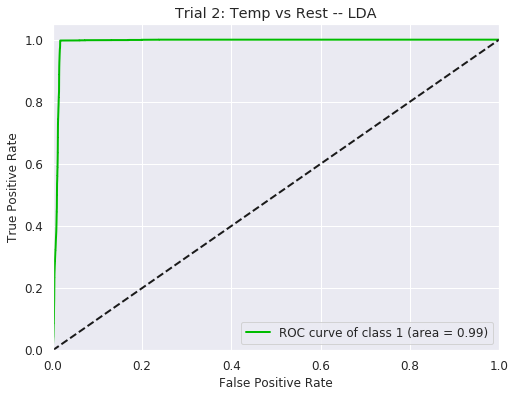

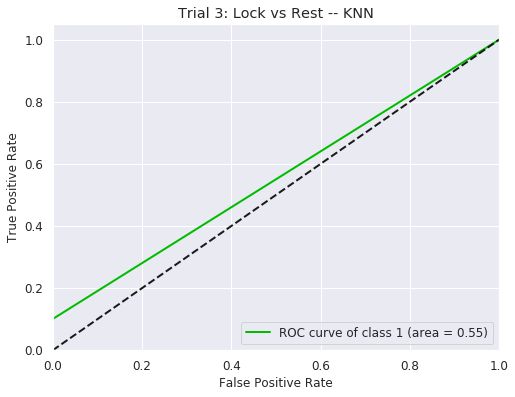

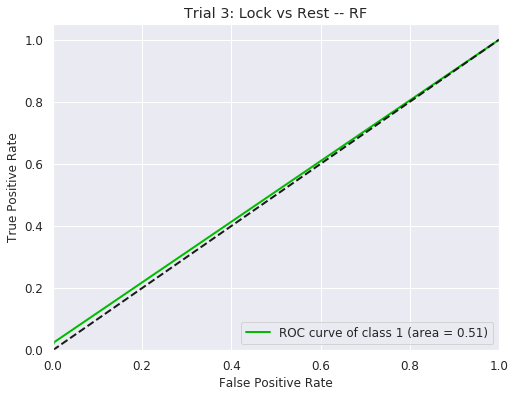

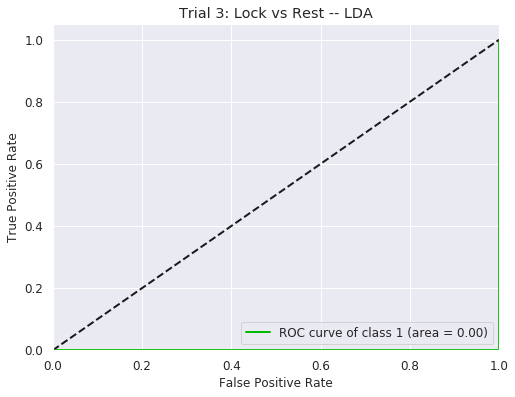

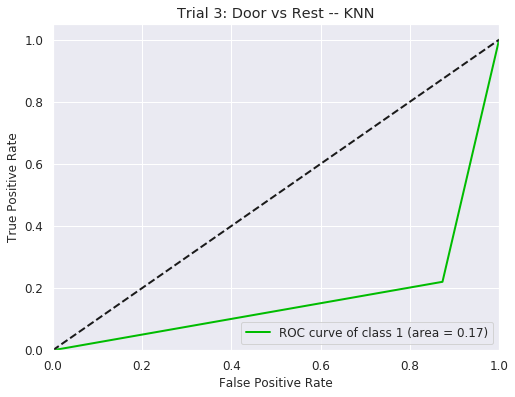

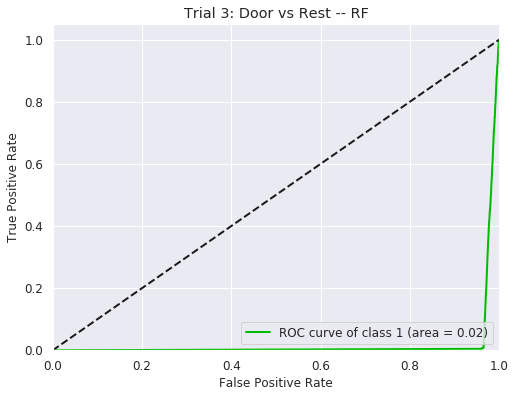

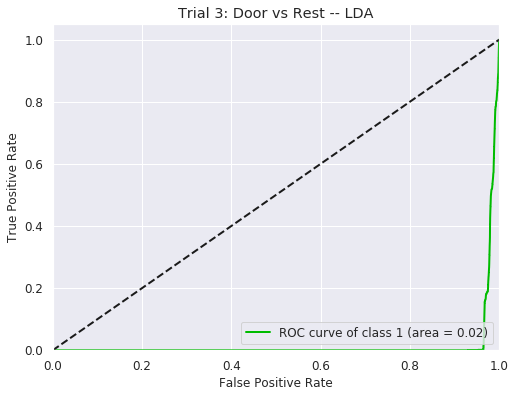

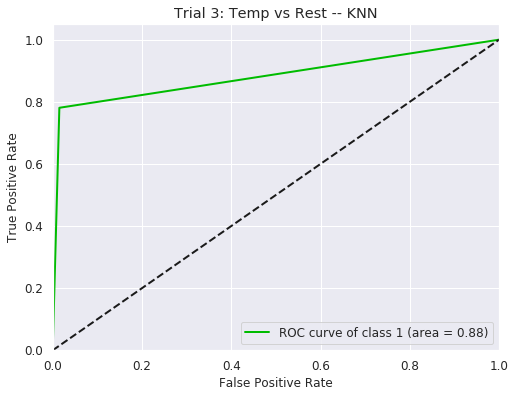

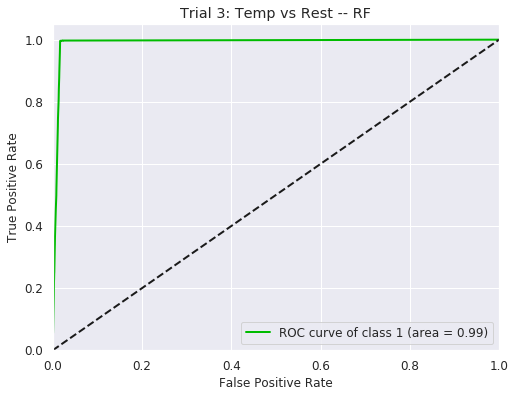

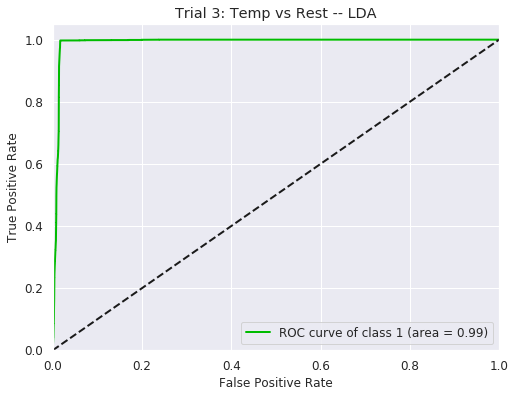

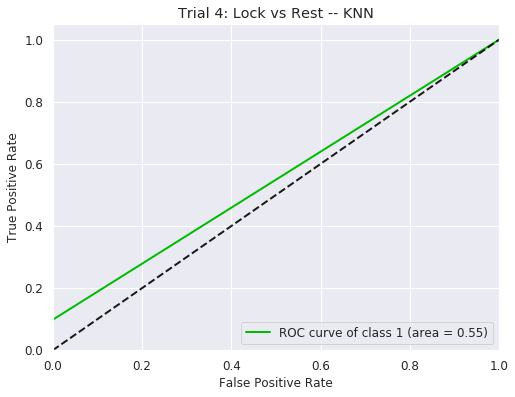

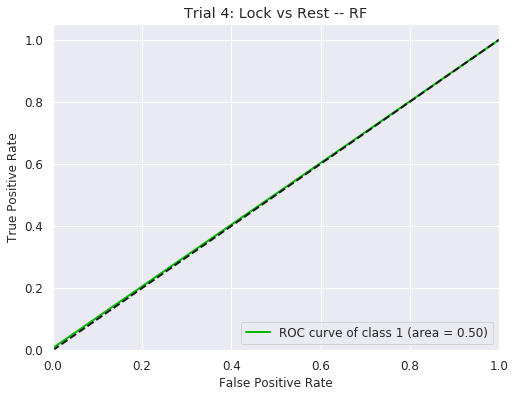

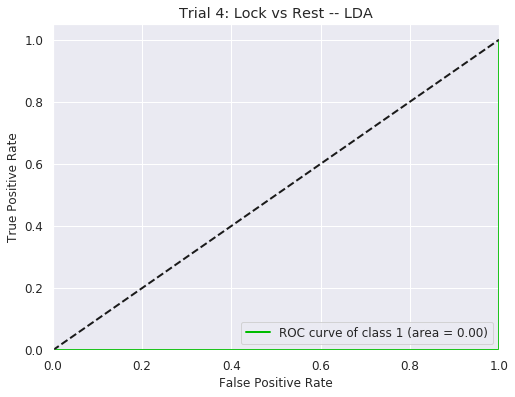

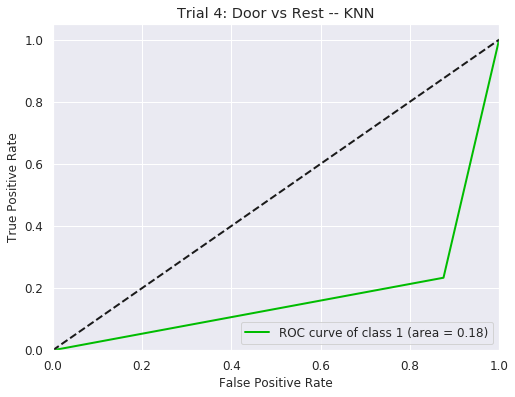

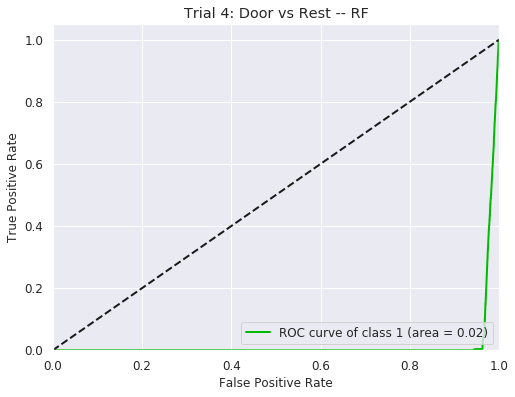

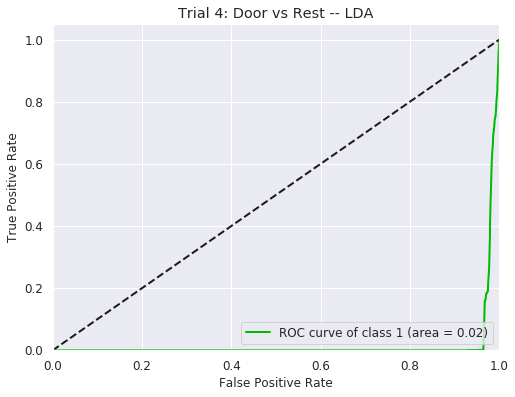

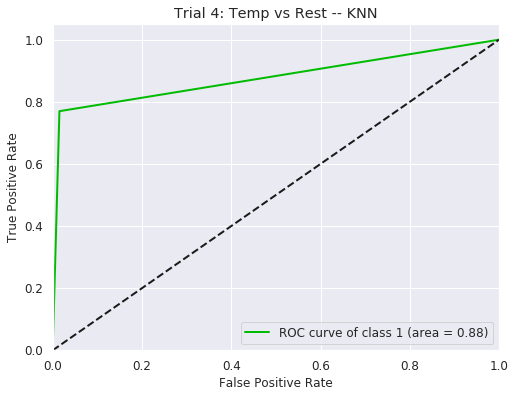

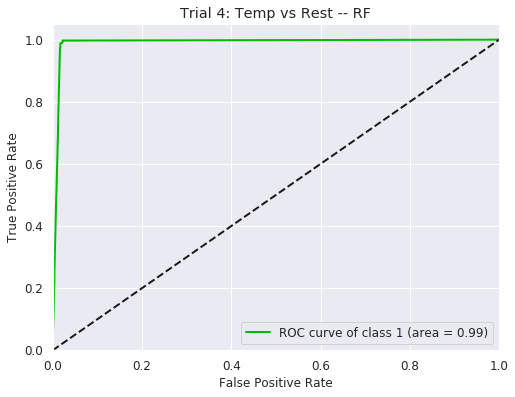

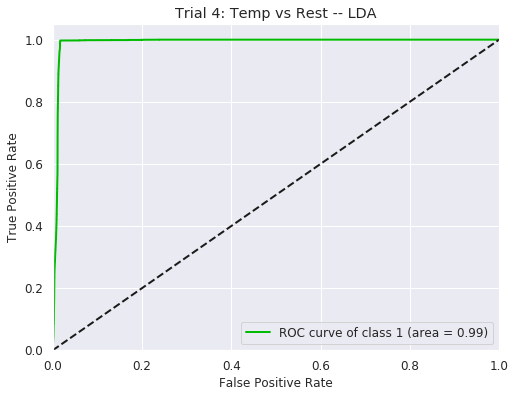

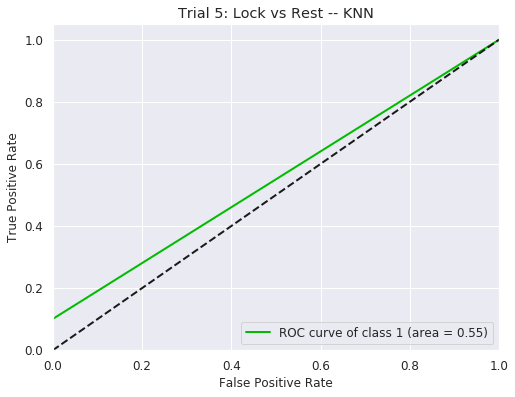

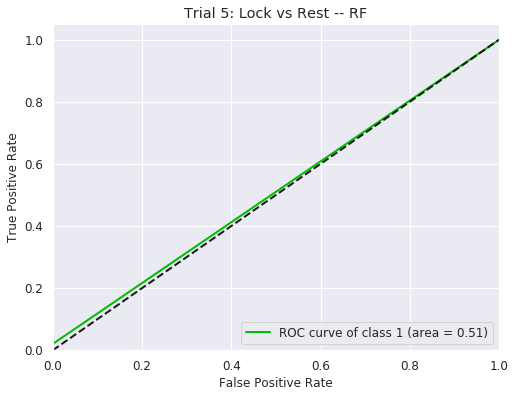

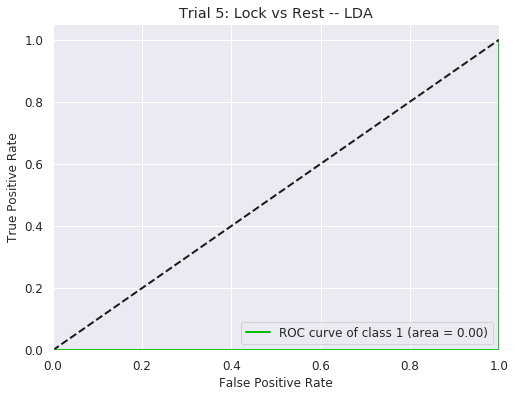

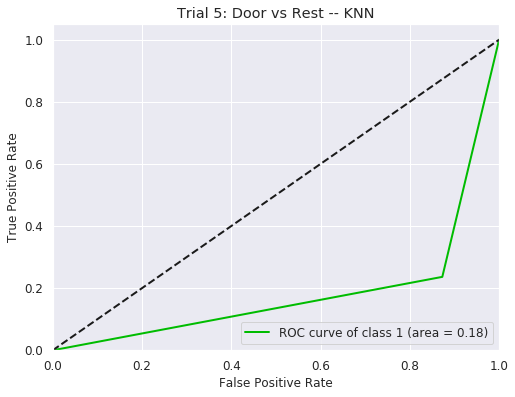

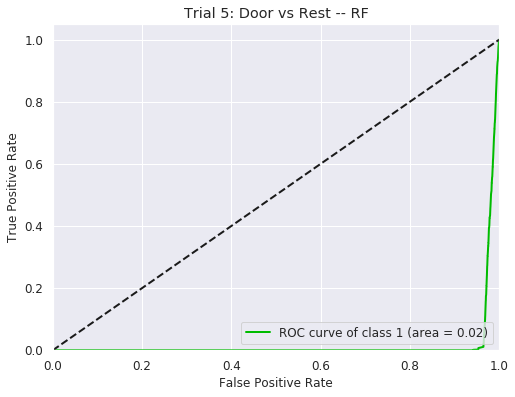

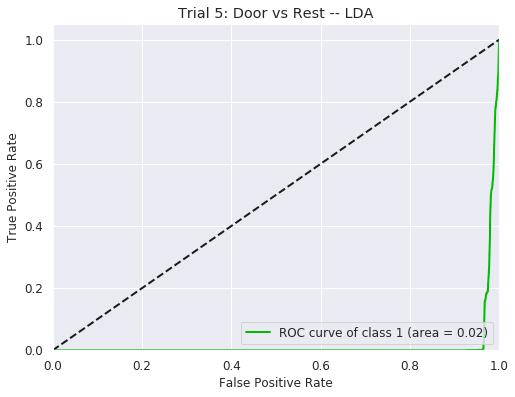

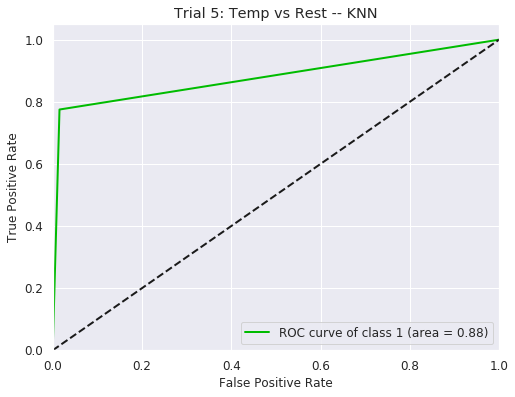

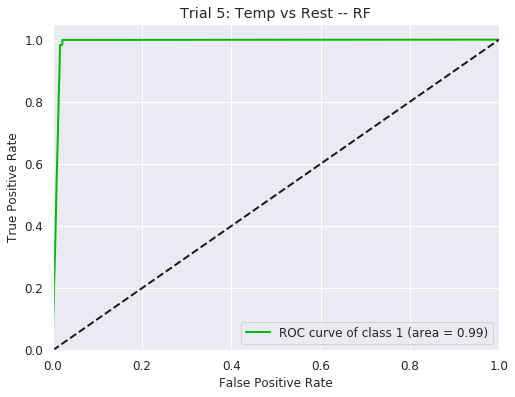

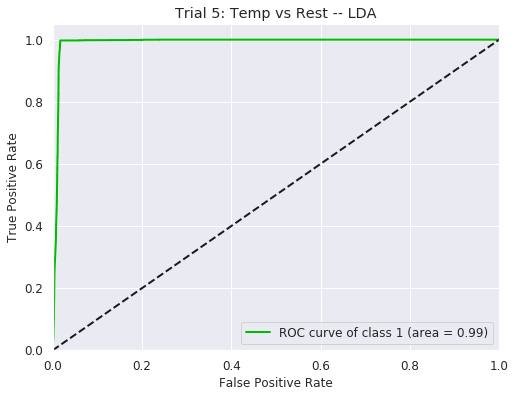

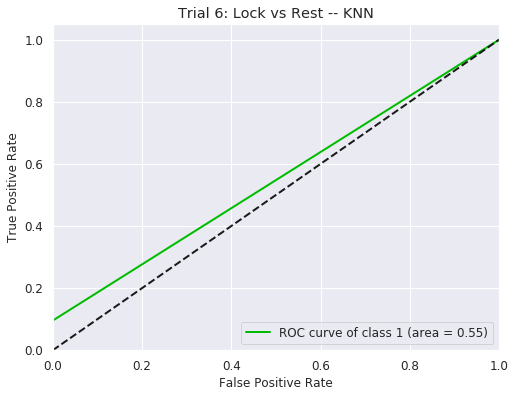

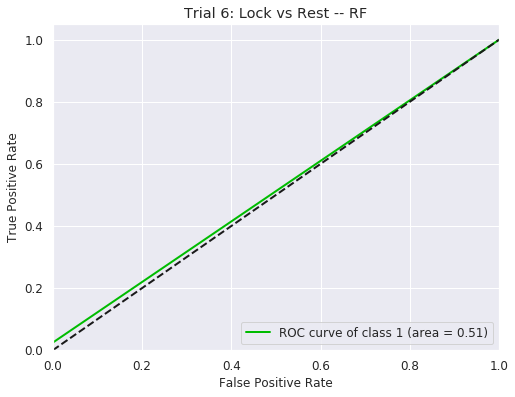

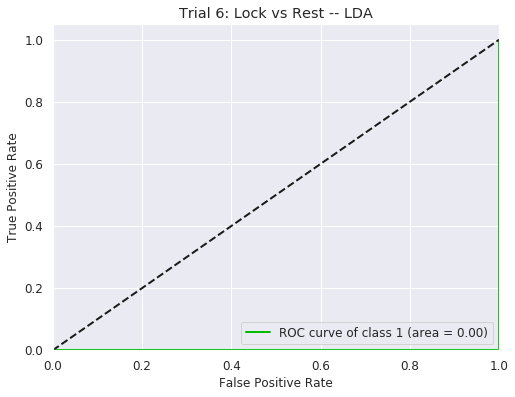

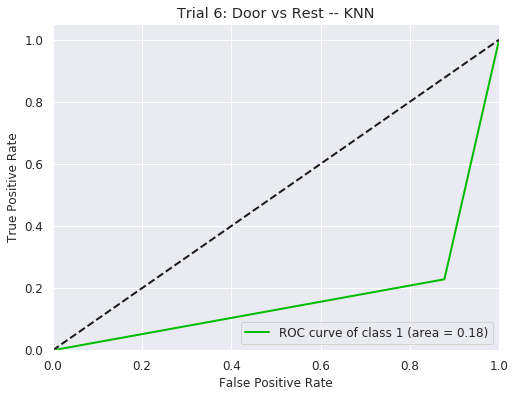

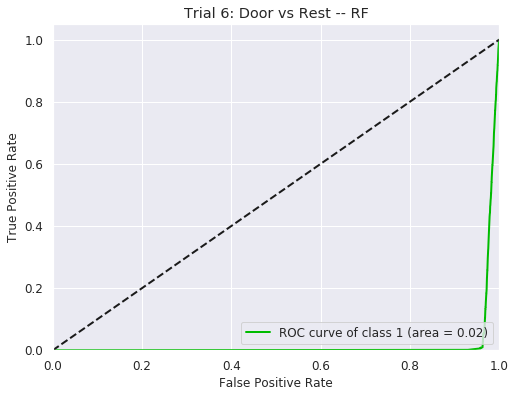

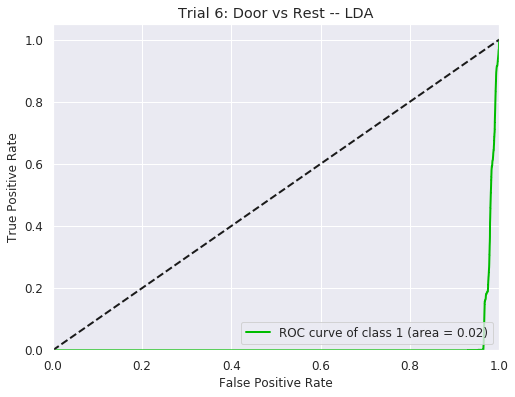

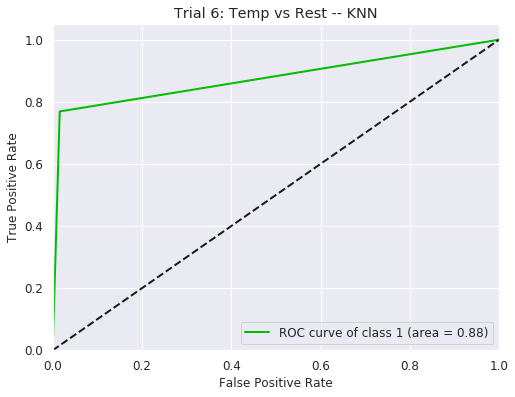

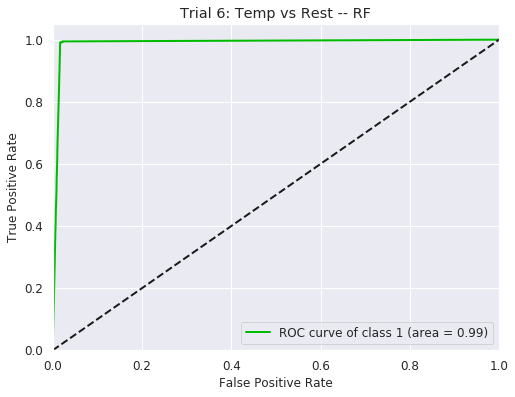

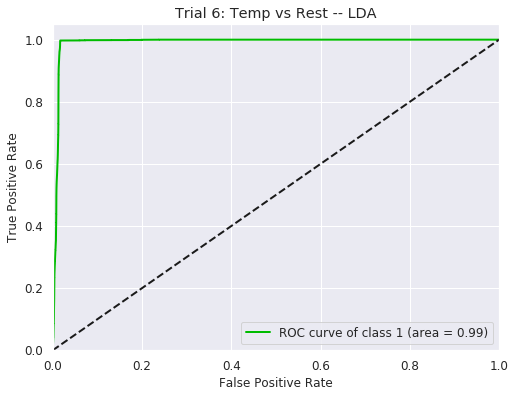

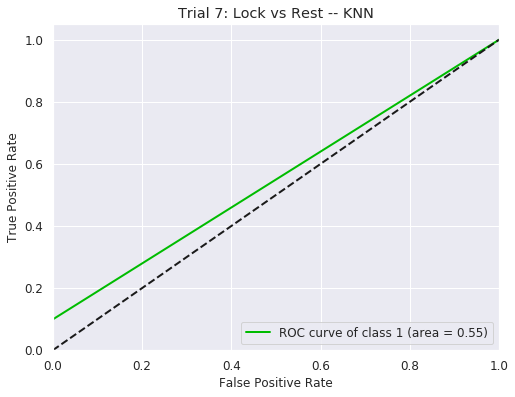

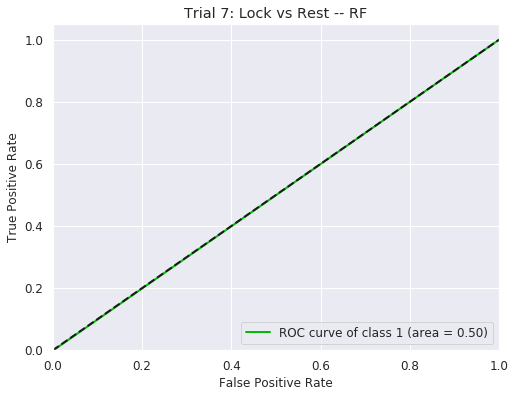

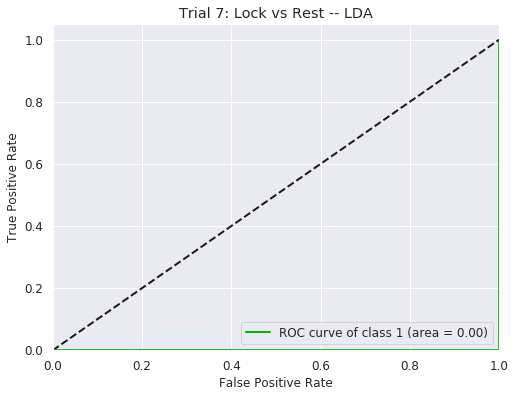

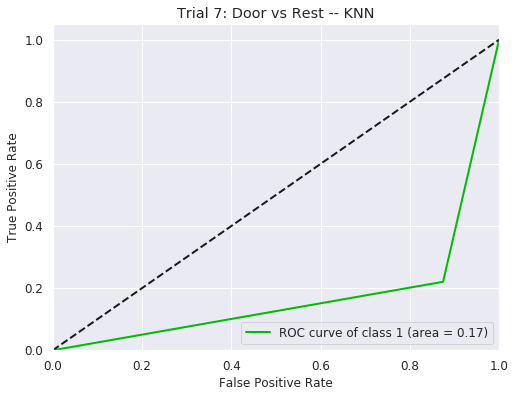

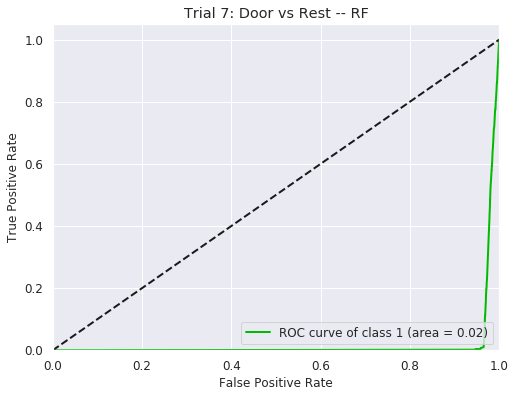

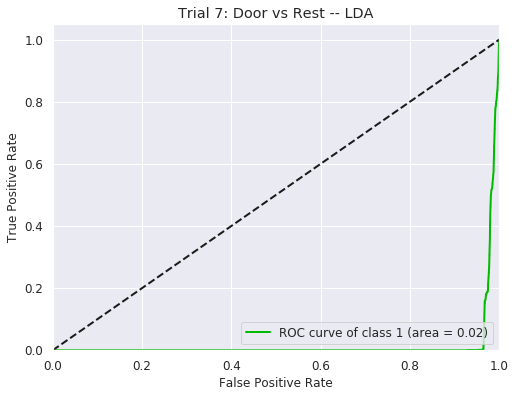

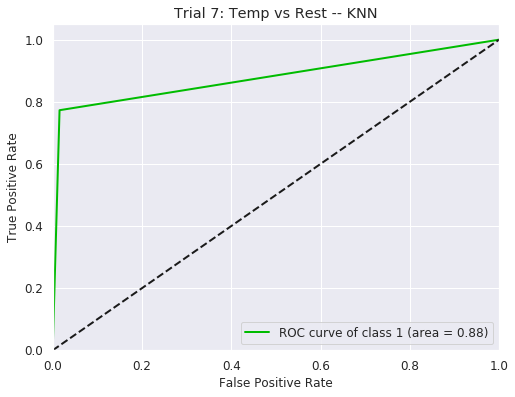

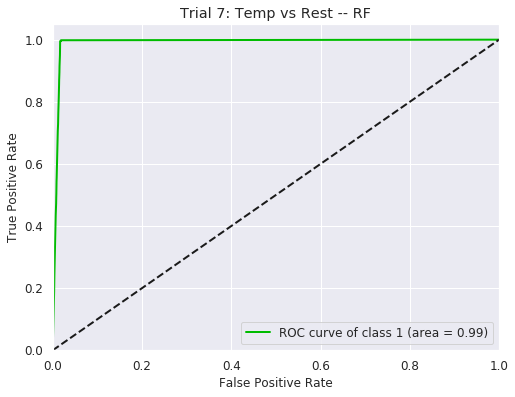

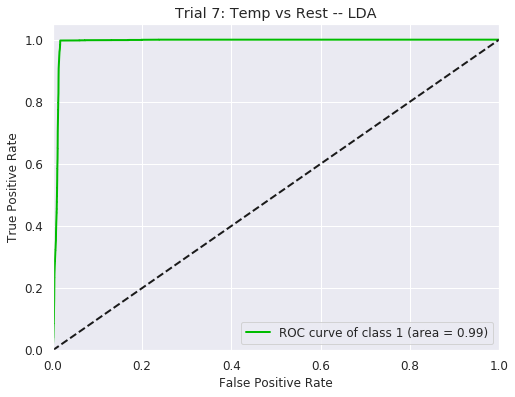

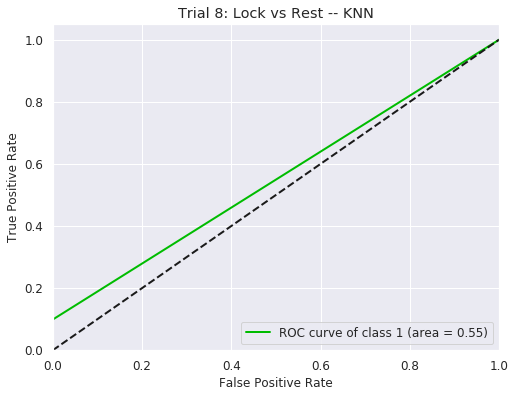

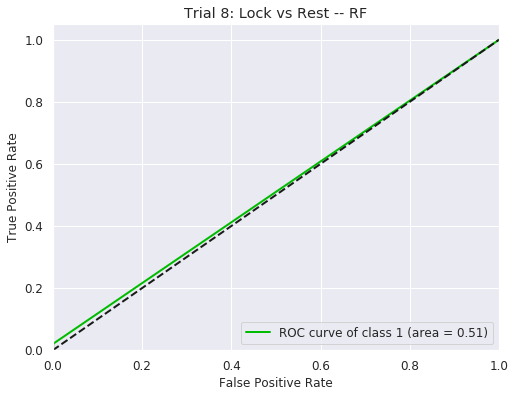

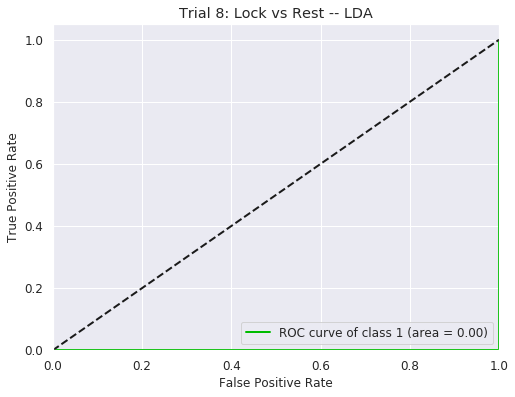

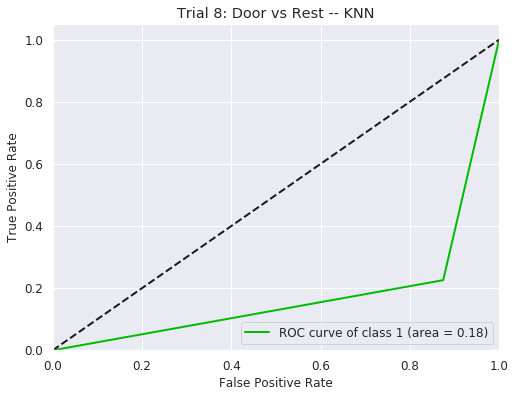

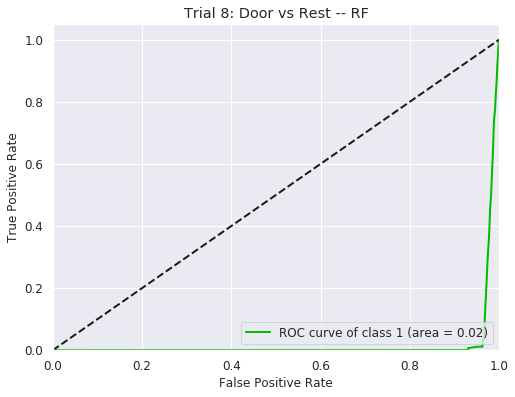

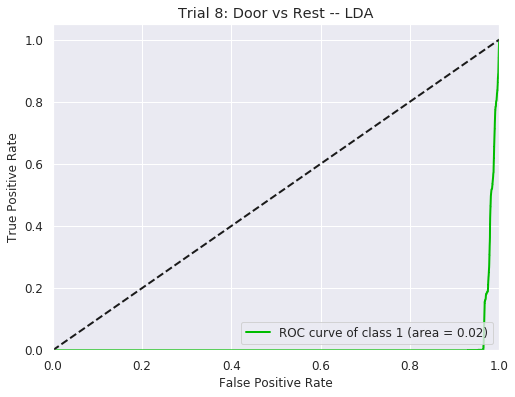

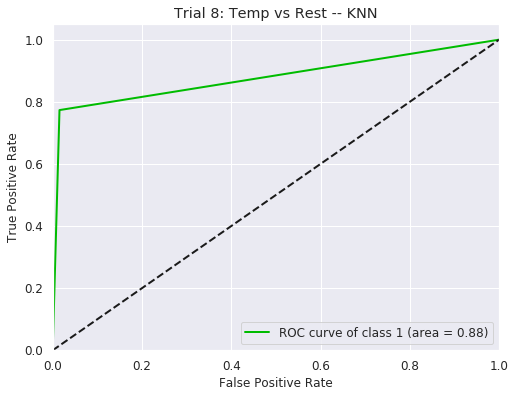

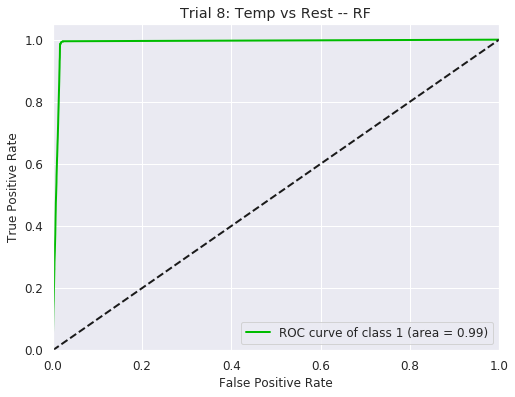

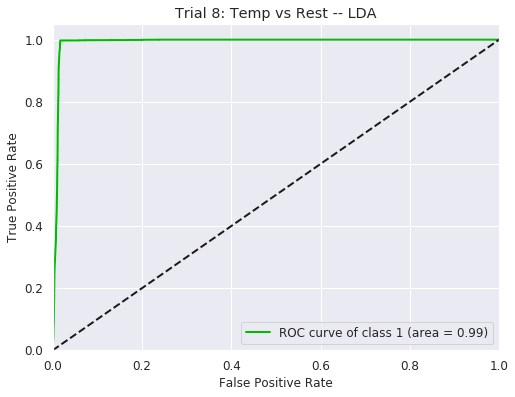

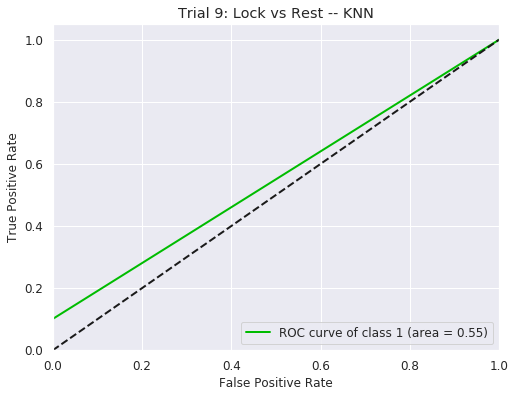

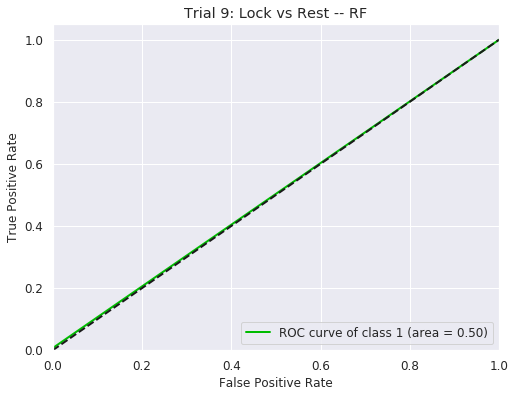

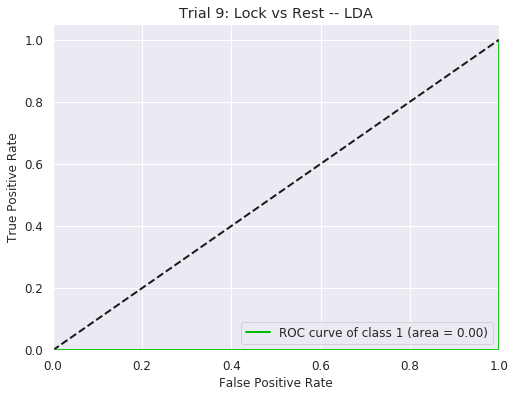

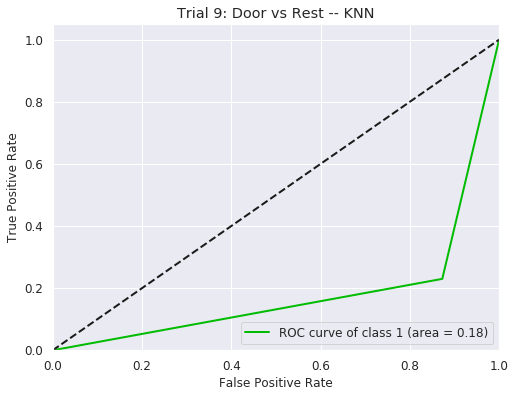

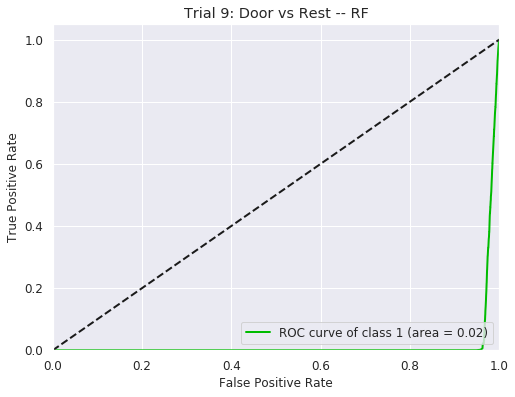

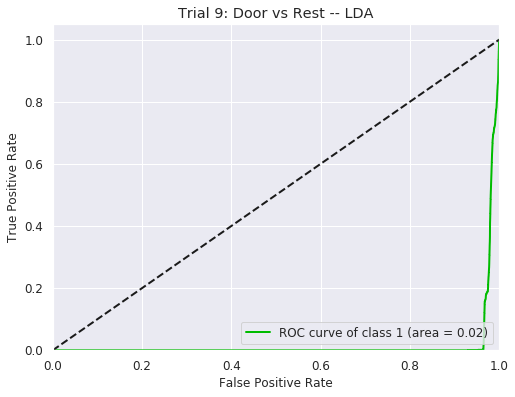

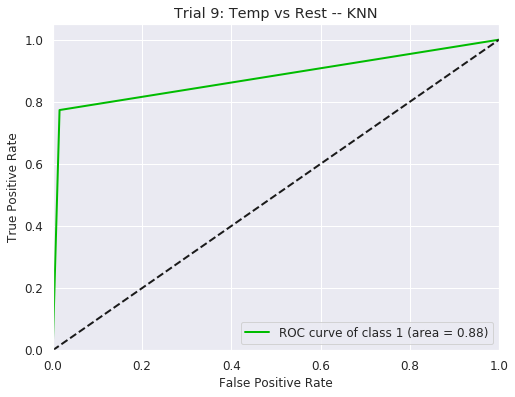

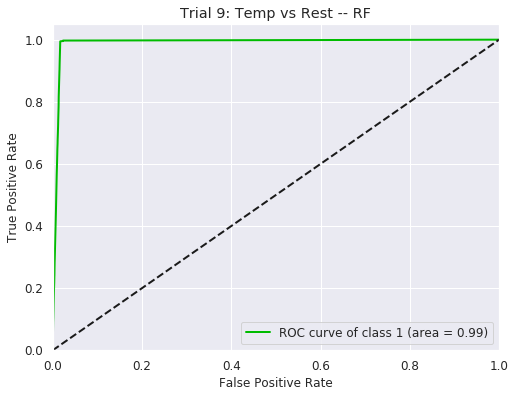

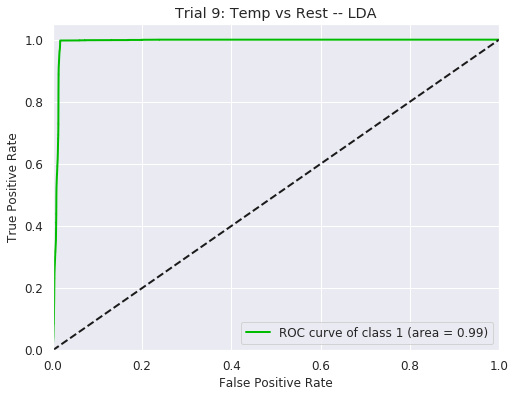

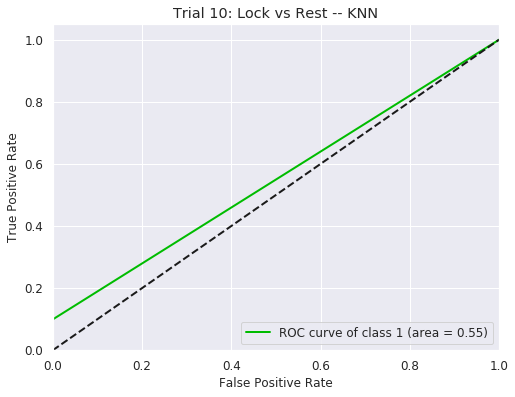

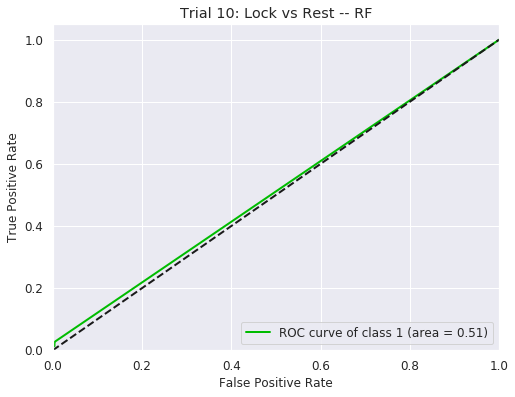

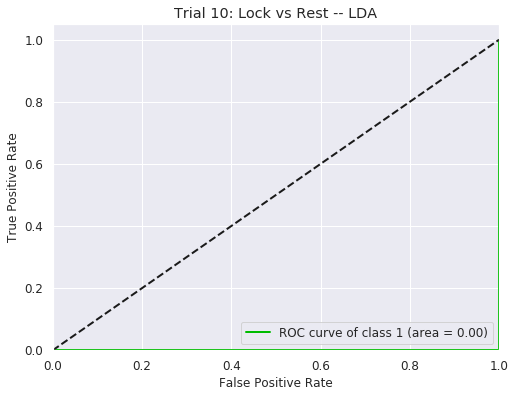

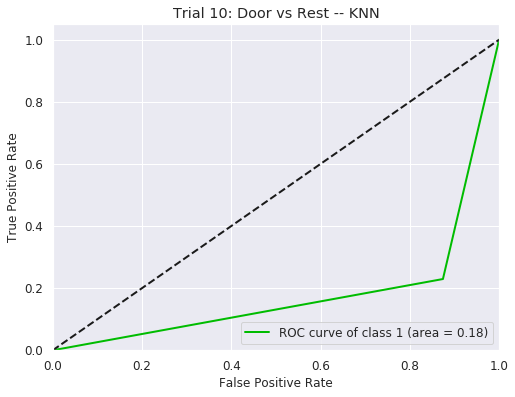

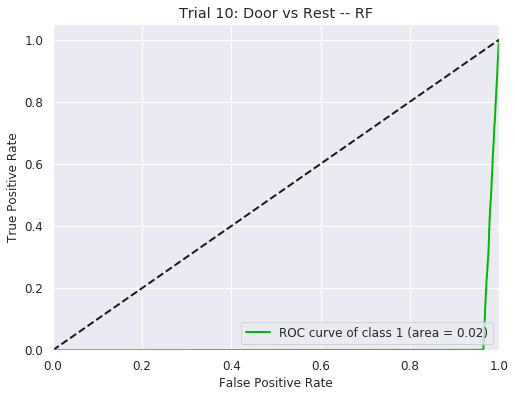

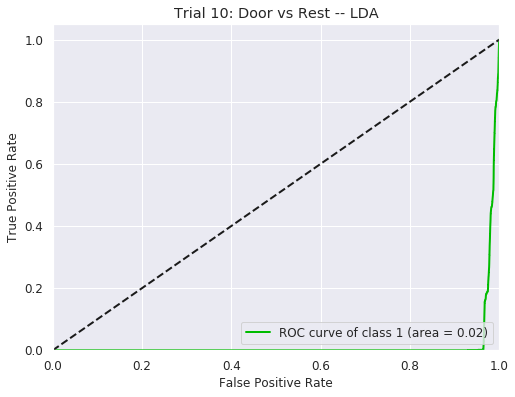

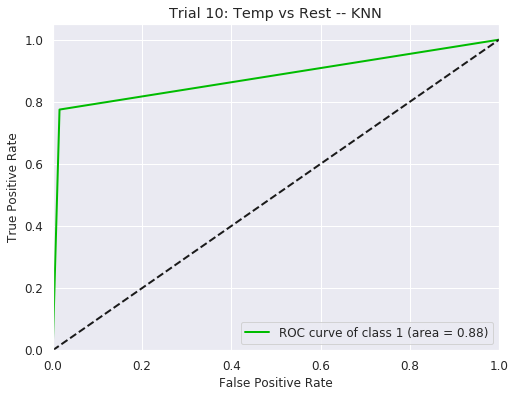

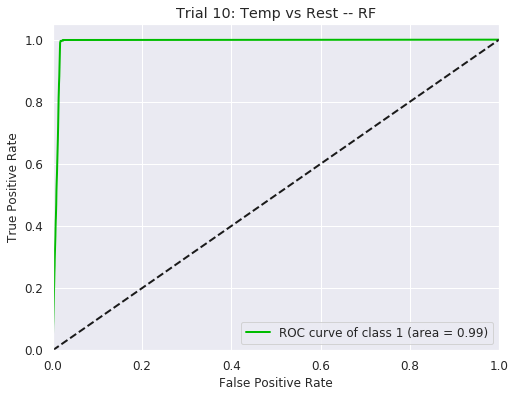

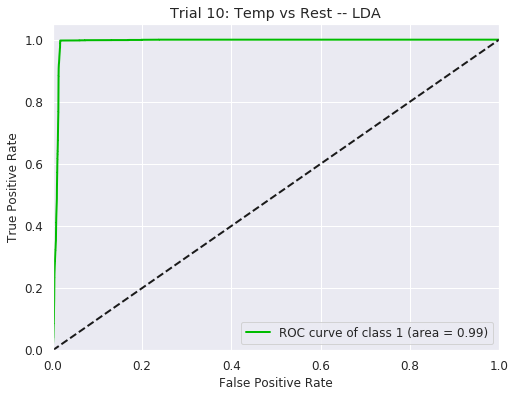

In [10]:
# Plotting ROC curves
sns.set(font_scale=1)
aucs = []
for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()
    
    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']

            # Calculate, store auc
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            aucs.append(auc)
            
            
            # Plot ROC curve
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));
            

### Print csv reports

In [11]:
df_alloutput = b.store_trial_results(trial_results)
df_alloutput['AUC'] = aucs
df_alloutput.to_csv('Results/ble-alltrials.csv', mode='w')

In [12]:
df_performance_device = b.report_metrics_across('Device', df_alloutput)
display(df_performance_device)
df_performance_device.to_csv('Results/ble-devtype-performance.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
lock,0.391954,0.195559,0.072629,0.117325,0.128793,0.047832,0.893777,0.125285,0.046530,0.352675,0.254035,0.094346
door,0.079308,0.070892,0.026329,0.093746,0.099021,0.036775,0.001723,0.001867,0.000693,0.070925,0.076313,0.028342
temp,0.781085,0.205258,0.076231,0.989585,0.007489,0.002781,0.985028,0.014411,0.005352,0.953342,0.053746,0.019961


In [13]:
df_performance_classifier = b.report_metrics_across('Classifier', df_alloutput)
display(df_performance_classifier)
df_performance_classifier.to_csv('Results/ble-devtype-classifier.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
KNN,0.534994,0.291527,0.108270,0.437499,0.397189,0.147512,0.665283,0.475403,0.176560,0.534994,0.291527,0.108270
RF,0.502012,0.383346,0.142371,0.344301,0.460610,0.171066,0.633734,0.459322,0.170588,0.505850,0.403384,0.149813
LDA,0.215342,0.212736,0.079008,0.418856,0.436783,0.162217,0.581512,0.431162,0.160130,0.336097,0.471127,0.174972


### Time Performance

In [14]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in y_list:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 23.7659349442 seconds
(Door, KNN) : 4.85985207558 seconds
(Door, RF) : 1.28886413574 seconds
(Door, LDA) : 0.663428068161 seconds
(Lock, KNN) : 4.77433896065 seconds
(Lock, RF) : 1.13010787964 seconds
(Lock, LDA) : 0.654134988785 seconds
(Temp, KNN) : 4.74234199524 seconds
(Temp, RF) : 1.16415786743 seconds
(Temp, LDA) : 0.645348072052 seconds

Trial  1
Total time: 24.4196560383 seconds
(Door, KNN) : 4.87666201591 seconds
(Door, RF) : 1.28822493553 seconds
(Door, LDA) : 0.652983903885 seconds
(Lock, KNN) : 4.81854510307 seconds
(Lock, RF) : 1.11155819893 seconds
(Lock, LDA) : 0.658306837082 seconds
(Temp, KNN) : 5.31386399269 seconds
(Temp, RF) : 1.19220280647 seconds
(Temp, LDA) : 0.720520973206 seconds

Trial  2
Total time: 23.9855909348 seconds
(Door, KNN) : 4.99655795097 seconds
(Door, RF) : 1.34029507637 seconds
(Door, LDA) : 0.664442062378 seconds
(Lock, KNN) : 4.83804607391 seconds
(Lock, RF) : 1.14035797119 seconds
(Lock, LDA) : 0.654611110687 seconds
(Temp

### Feature Importance

In [15]:
df_featImp = pd.DataFrame()
for i,f in enumerate(b.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [16]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [17]:
feat_imp = df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False)
display(feat_imp)
feat_imp.to_csv('Results/ble-feature_importance.csv', mode='w')

,Mean,StdDev,CI_MOE
PacketLength,0.294076,0.146255,0.084440
BLE_LL_Length,0.260406,0.128948,0.074448
SCAN_RSP,0.193643,0.141941,0.081949
Assoc_Packets,0.148489,0.103636,0.059835
ADV_IND,0.082266,0.045775,0.026428
SCAN_REQ,0.013553,0.014357,0.008289
Time,0.006441,0.003991,0.002304
Channel_12,0.000601,0.000854,0.000493
Channel_39,0.000356,0.000704,0.000406
Channel_0,0.000097,0.000138,0.000080


### Plots

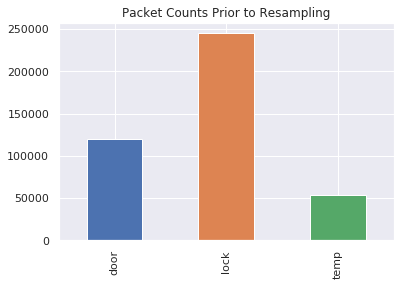

In [18]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

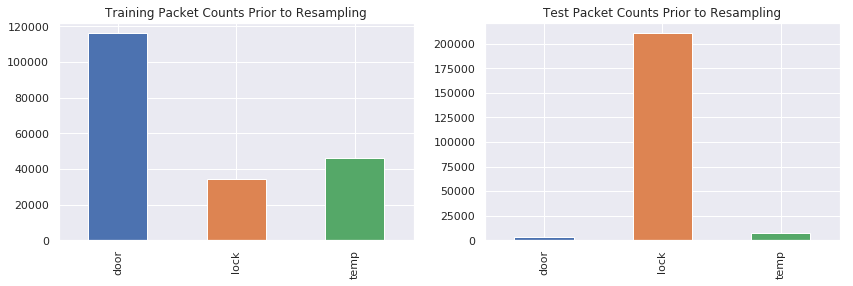

In [19]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


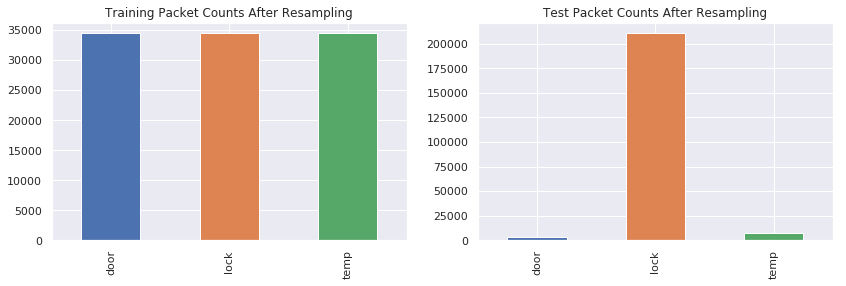

In [20]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[ble_devicetypes].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
